In [1]:
#Importamos las librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
import joblib

# Ejercicio 1

### Cargamos y Procesamos Datos

In [2]:
#Cargar los datos
demand = pd.read_csv('dataset_demand_acumulate.csv')

In [3]:
#Damos formatoa las fecha y hacemos index
demand.index = pd.to_datetime(demand['year_month'], format = '%Y/%m') 
demand.sort_index(inplace=True)
demand.drop('year_month', axis=1,inplace=True)

In [4]:
#Revisamos las columnas a que tipo de datos corresponden
demand.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 64 entries, 2017-01-01 to 2022-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Demand  64 non-null     float64
dtypes: float64(1)
memory usage: 1.0 KB


In [5]:
#Descripción estadística
demand.describe()

,Demand
count,64.000000
mean,2600.044986
std,1943.995938
min,217.314949
25%,1034.370651
50%,1947.817229
75%,4216.465081
max,7686.307292


In [6]:
#Numero total de muestras
n = len(demand)
#Tamaño de datos train
train_size = int(n * 0.8)

#Definimos los index para cada dataset
train_indices = list(range(0, train_size))
test_indices = list(range(train_size, n))

#Separamos los datos en train(80%) y test (20%)
train_df, test_df = demand.iloc[train_indices], demand.iloc[test_indices]

### Construimos el Modelo

In [7]:
#Contruimos el modelo sin hiperparametros
model_orig = ForecasterAutoreg(
            regressor = RandomForestRegressor(random_state=123),
                 lags = 4)

#Entrenamos el modelo con los datos de entrenamiento y validación
model_orig.fit(y=train_df['Demand'])

# Realizar predicciones sobre el conjunto de prueba
predictions = model_orig.predict(steps=len(test_df))

/home/jsanchezo/.local/lib/python3.10/site-packages/skforecast/utils/utils.py:1058: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/home/jsanchezo/.local/lib/python3.10/site-packages/skforecast/utils/utils.py:1058: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/home/jsanchezo/.local/lib/python3.10/site-packages/skforecast/utils/utils.py:1120: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


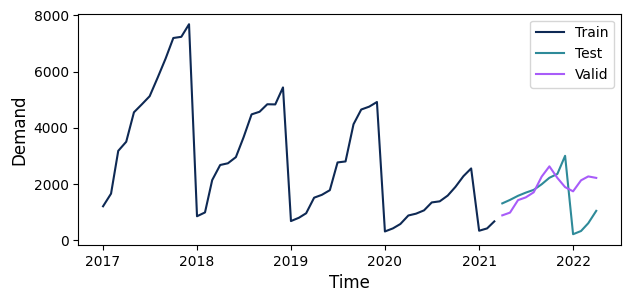

In [8]:
#Graficamos los datos de train, validation y test
fig, ax = plt.subplots(figsize=( 7 , 3 )) 
ax.plot(train_df.index, train_df.Demand, color='#0E2954', label = 'Train')
ax.plot(test_df.index, test_df.Demand, color='#2E8A99', label = 'Test')
ax.plot(test_df.index, predictions.values, color='#A85CF9', label = 'Valid')

ax.set_ylabel('Demand', fontsize=12)
ax.set_xlabel('Time', fontsize=12)
ax.legend()

In [9]:
#RMSE en el conjunto de prueba
rmse_test = mean_squared_error(test_df['Demand'], predictions, squared=False)
print(f"El RMSE en el conjunto de prueba: {rmse_test:.2f}")

#RMSE relativo
rmse_relative = (rmse_test/test_df.mean()) * 100
print(f"RMSE Relativo (%): {rmse_relative.values[0]:.2f}%")

El RMSE en el conjunto de prueba: 947.32
RMSE Relativo (%): 62.77%


In [10]:
# GridSearch hiperparametros 
model_hyp = ForecasterAutoreg(
        regressor = RandomForestRegressor(random_state=123),
        lags = 5)

# Lags used as predictors
lags_grid = [3, 10, [1, 2, 3, 20]]

# Regressor hyperparameters
param_grid = {
    'n_estimators': np.arange(10,110,10).tolist(),
    'max_depth': np.arange(5,105,5).tolist()}

results = grid_search_forecaster(
              forecaster = model_hyp,
              y = demand.Demand.reset_index()['Demand'],
              param_grid = param_grid,
              lags_grid = lags_grid,
              steps = len(test_df),
              refit = False,
              metric = 'mean_squared_error',
              initial_train_size = len(train_df),
              fixed_train_size = False,
              return_best = True,
              n_jobs = 'auto',
              verbose = False,
              show_progress = True
          )

results

Number of models compared: 600.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/200 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 20] 
  Parameters: {'max_depth': 5, 'n_estimators': 10}
  Backtesting metric: 254264.05718451893



,lags,lags_label,params,mean_squared_error,max_depth,n_estimators
400,"[1, 2, 3, 20]","[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 10}",2.542641e+05,5,10
203,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 40}",3.220850e+05,5,40
383,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 95, 'n_estimators': 40}",3.478194e+05,95,40
213,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 40}",3.478194e+05,10,40
333,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 70, 'n_estimators': 40}",3.478194e+05,70,40
...,...,...,...,...,...,...
70,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 40, 'n_estimators': 10}",5.106948e+06,40,10
60,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 35, 'n_estimators': 10}",5.106948e+06,35,10
50,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 30, 'n_estimators': 10}",5.106948e+06,30,10
140,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 75, 'n_estimators': 10}",5.106948e+06,75,10


In [11]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123,
                max_depth = 5, n_estimators =10),
                 lags = [1, 2, 3, 20] )

#El backtesting lo hacemos con refit e incremento de del train size
metric_hyp, predicted_backtest_hyp = backtesting_forecaster(
        forecaster = forecaster,
        y = demand.Demand.reset_index()['Demand'],
        steps = len(test_df),
        metric = 'mean_squared_error',
        initial_train_size = len(train_df),
        fixed_train_size = False,
        gap = 0,
        allow_incomplete_fold = True,
        refit = True,
        n_jobs = 'auto',
        verbose = True,
        show_progress = True)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 51
Number of observations used for backtesting: 13
    Number of folds: 1
    Number of steps per fold: 13
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   0 -- 50  (n=51)
    Validation: 51 -- 63  (n=13)



  0%|          | 0/1 [00:00<?, ?it/s]

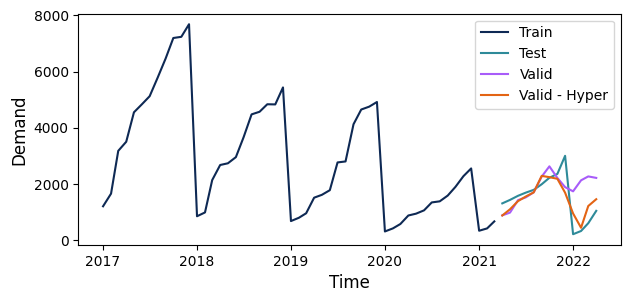

In [12]:
#Graficamos los datos de train, validation y test
fig, ax = plt.subplots(figsize=( 7 , 3 )) 
ax.plot(train_df.index, train_df.Demand, color='#0E2954', label = 'Train')
ax.plot(test_df.index, test_df.Demand, color='#2E8A99', label = 'Test')
ax.plot(test_df.index, predictions.values, color='#A85CF9', label = 'Valid')
ax.plot(test_df.index, predicted_backtest_hyp.values, color='#E36414', 
        label = 'Valid - Hyper')

ax.set_ylabel('Demand', fontsize=12)
ax.set_xlabel('Time', fontsize=12)
ax.legend()

In [13]:
#RMSE en el conjunto de prueba
rmse_test_hyp = mean_squared_error(test_df['Demand'], predicted_backtest_hyp, squared=False)
print(f"El RMSE en el conjunto de prueba: {rmse_test_hyp:.2f}")

#RMSE relativo
rmse_relative_hyp = (rmse_test_hyp/test_df.mean()) * 100
print(f"RMSE Relativo (%): {rmse_relative_hyp.values[0]:.2f}%")

El RMSE en el conjunto de prueba: 504.25
RMSE Relativo (%): 33.41%


In [14]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123,
                max_depth = 5, n_estimators =10),
                 lags = [1, 2, 3, 20] )

#Entrenamos el modelo con los datos de entrenamiento y validación
forecaster.fit(y=train_df['Demand'])

# Realizar predicciones sobre el conjunto de prueba
forecast = forecaster.predict(steps=3)

/home/jsanchezo/.local/lib/python3.10/site-packages/skforecast/utils/utils.py:1058: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/home/jsanchezo/.local/lib/python3.10/site-packages/skforecast/utils/utils.py:1058: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/home/jsanchezo/.local/lib/python3.10/site-packages/skforecast/utils/utils.py:1120: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [15]:
predictions_df = pd.DataFrame(forecast.values, 
                index=pd.date_range('2022-05','2022-07', freq='MS'),
                columns=['Demand'])
#Unimos los datos de pronostico al archivo
demand_forecast = pd.concat([demand,predictions_df], axis = 0)

In [19]:
demand_forecast.to_csv('demand_forecast.csv')

### Resultados

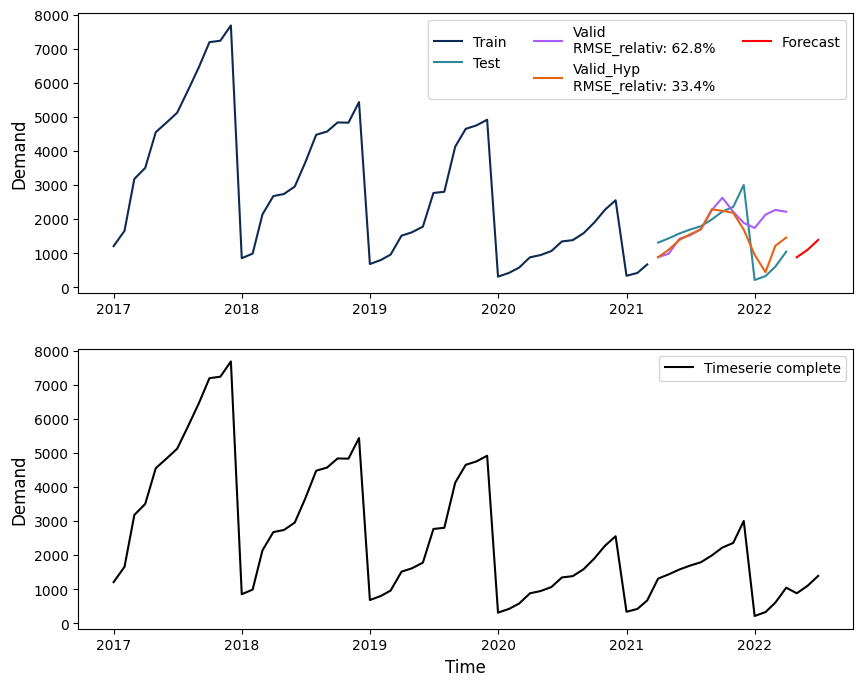

In [17]:
#Graficamos los datos de train, validation y test
fig = plt.figure(figsize=(10,8)) 
ax = fig.add_subplot(211)
ax.plot(train_df.index, train_df.Demand, color='#0E2954', label = 'Train')
ax.plot(test_df.index, test_df.Demand, color='#2E8A99', label = 'Test')
label_valid = f'Valid\nRMSE_relativ: {rmse_relative[0]:.1f}%'
ax.plot(test_df.index, predictions.values, color='#A85CF9', label = label_valid)
label_valHyp = f'Valid_Hyp\nRMSE_relativ: {rmse_relative_hyp[0]:.1f}%'
ax.plot(test_df.index, predicted_backtest_hyp.values, color='#E36414', 
        label = label_valHyp)
ax.plot(predictions_df.index, predictions_df.values, 
        color='#FF0000', label = 'Forecast')

ax.set_ylabel('Demand', fontsize=12)
#ax.set_xlabel('Time', fontsize=12)
ax.legend(fontsize = 10, ncol = 3)

ax1 = fig.add_subplot(212)
ax1.plot(demand_forecast.index, demand_forecast.values, 
        color='#000000', label = 'Timeserie complete')
ax1.set_ylabel('Demand', fontsize=12)
ax1.set_xlabel('Time', fontsize=12)
ax1.legend(fontsize = 10, ncol = 1)
plt.savefig(f'Forecast_Demand.jpg',bbox_inches="tight",dpi = 200)


# Ejercicio 2

### Exploramos los datos

In [19]:
alpha_betha.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   autoID            7043 non-null   object 
 1   SeniorCity        7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   Service1          7043 non-null   object 
 5   Service2          7043 non-null   object 
 6   Security          7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  Contract          7043 non-null   object 
 11  PaperlessBilling  7043 non-null   object 
 12  PaymentMethod     7043 non-null   object 
 13  Charges           7043 non-null   float64
 14  Demand            7043 non-null   object 
 15  Class             7043 non-null   object 
dtypes: float64(1), int64(1), object(14)
memory

In [20]:
alpha_betha.head(10)

,autoID,SeniorCity,Partner,Dependents,Service1,Service2,Security,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,Charges,Demand,Class
0,7590-VHVEG,0,Yes,No,No,No phone service,No,Yes,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,Alpha
1,5575-GNVDE,0,No,No,Yes,No,Yes,No,Yes,No,One year,No,Mailed check,56.95,1889.5,Alpha
2,3668-QPYBK,0,No,No,Yes,No,Yes,Yes,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Betha
3,7795-CFOCW,0,No,No,No,No phone service,Yes,No,Yes,Yes,One year,No,Bank transfer (automatic),42.30,1840.75,Alpha
4,9237-HQITU,0,No,No,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Betha
5,9305-CDSKC,0,No,No,Yes,Yes,No,No,Yes,No,Month-to-month,Yes,Electronic check,99.65,820.5,Betha
6,1452-KIOVK,0,No,Yes,Yes,Yes,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,Alpha
7,6713-OKOMC,0,No,No,No,No phone service,Yes,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,Alpha
8,7892-POOKP,0,Yes,No,Yes,Yes,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Betha
9,6388-TABGU,0,No,Yes,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,Alpha


In [21]:
to_predict

,autoID,SeniorCity,Partner,Dependents,Service1,Service2,Security,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,Charges,Demand,Class
0,9695-TERGH,0,No,No,Yes,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,96.05,NaN,NaN
1,5247-VRIOW,0,No,No,Yes,No,Yes,No,No,Yes,Month-to-month,No,Mailed check,53.45,NaN,NaN
2,5731-DDJUB,0,No,No,Yes,No,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),19.70,NaN,NaN


Text(0.5, 1.0, 'Conteo de registro según su clase')

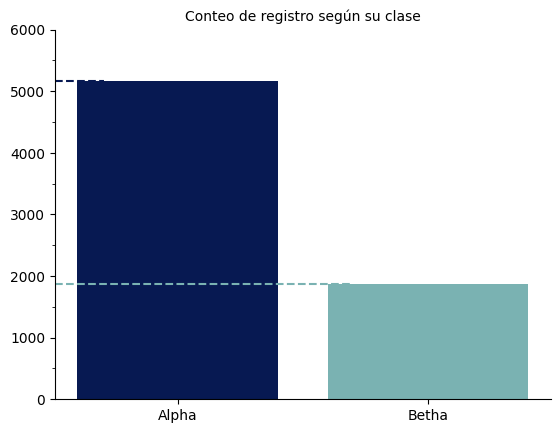

In [22]:
#Analizamos la cantidad de alpha y betha
alpha = alpha_betha[alpha_betha.Class == 'Alpha']
betha = alpha_betha[alpha_betha.Class == 'Betha']

x_bar = ['Alpha', 'Betha']
y_bar = [alpha['Class'].count(),
        betha['Class'].count()]
fig, ax = plt.subplots()
ax.bar(x = x_bar, height = y_bar, color = ['#071952','#7AB2B2'])
ax.tick_params(axis = 'both',labelcolor='#000000', labelsize = 10,)
ax.yaxis.set_major_locator(ticker.MultipleLocator(1000))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(500))
ax.set_ylim(0,6000)

ax.axhline(y = y_bar[0],xmax = .1, 
           ls = '--', color = '#071952')
ax.axhline(y = y_bar[1],xmax = .6, 
           ls = '--', color = '#7AB2B2')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Conteo de registro según su clase',size = 10)

In [25]:
pd.get_dummies(alpha_betha)

,SeniorCity,Charges,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,Service1_No,Service1_Yes,Service2_No,Service2_No phone service,...,Demand_996.85,Demand_996.95,Demand_997.65,Demand_997.75,Demand_998.1,Demand_999.45,Demand_999.8,Demand_999.9,Class_Alpha,Class_Betha
0,0,29.85,0,1,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0,56.95,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0
2,0,53.85,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,42.30,1,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,0,70.70,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,84.80,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
7039,0,103.20,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
7040,0,29.60,0,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
7041,1,74.40,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [51]:
alpha_betha[alpha_betha.Demand == ' ']

,autoID,SeniorCity,Partner,Dependents,Service1,Service2,Security,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,Charges,Demand,Class
488,4472-LVYGI,0,Yes,Yes,No,No phone service,Yes,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),52.55,,Alpha
753,3115-CZMZD,0,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,Alpha
936,5709-LVOEQ,0,Yes,Yes,Yes,No,Yes,Yes,Yes,No,Two year,No,Mailed check,80.85,,Alpha
1082,4367-NUYAO,0,Yes,Yes,Yes,Yes,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,Alpha
1340,1371-DWPAZ,0,Yes,Yes,No,No phone service,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),56.05,,Alpha
3331,7644-OMVMY,0,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,Alpha
3826,3213-VVOLG,0,Yes,Yes,Yes,Yes,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,Alpha
4380,2520-SGTTA,0,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,Alpha
5218,2923-ARZLG,0,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,Alpha
6670,4075-WKNIU,0,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Two year,No,Mailed check,73.35,,Alpha


In [3]:
#Procesamos y/o eliminamos columnas

#Eliminamos filas donde no hay valores Demand
alpha_betha = alpha_betha[alpha_betha.Demand != ' ']
alpha_betha_new = alpha_betha.copy()
alpha_betha_new.drop(['autoID','Demand', 'Class'], axis = 1, inplace=True)
#Convertimos categorias a valores
alpha_betha_new = pd.get_dummies(alpha_betha_new)

#Agregamos nuevamente las columnas Demand y Class del original
alpha_betha_new['Demand'] = alpha_betha['Demand'] 
alpha_betha_new['Class'] = alpha_betha['Class'] 

#Convertimos Alpha y Betha en 0 y 1
label_encoder = LabelEncoder()
# Ajustamos y transformamos los datos
alpha_betha_new['Class'] = label_encoder.fit_transform(alpha_betha_new['Class'])

In [53]:
alpha_betha_new.head(5)

,SeniorCity,Charges,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,Service1_No,Service1_Yes,Service2_No,Service2_No phone service,...,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Demand,Class
0,0,29.85,0,1,1,0,1,0,0,1,...,0,0,0,1,0,0,1,0,29.85,0
1,0,56.95,1,0,1,0,0,1,1,0,...,1,0,1,0,0,0,0,1,1889.5,0
2,0,53.85,1,0,1,0,0,1,1,0,...,0,0,0,1,0,0,0,1,108.15,1
3,0,42.30,1,0,1,0,1,0,0,1,...,1,0,1,0,1,0,0,0,1840.75,0
4,0,70.70,1,0,1,0,0,1,1,0,...,0,0,0,1,0,0,1,0,151.65,1


In [54]:
alpha_betha_new

,SeniorCity,Charges,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,Service1_No,Service1_Yes,Service2_No,Service2_No phone service,...,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Demand,Class
0,0,29.85,0,1,1,0,1,0,0,1,...,0,0,0,1,0,0,1,0,29.85,0
1,0,56.95,1,0,1,0,0,1,1,0,...,1,0,1,0,0,0,0,1,1889.5,0
2,0,53.85,1,0,1,0,0,1,1,0,...,0,0,0,1,0,0,0,1,108.15,1
3,0,42.30,1,0,1,0,1,0,0,1,...,1,0,1,0,1,0,0,0,1840.75,0
4,0,70.70,1,0,1,0,0,1,1,0,...,0,0,0,1,0,0,1,0,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,84.80,0,1,0,1,0,1,0,0,...,1,0,0,1,0,0,0,1,1990.5,0
7039,0,103.20,0,1,0,1,0,1,0,0,...,1,0,0,1,0,1,0,0,7362.9,0
7040,0,29.60,0,1,0,1,1,0,0,1,...,0,0,0,1,0,0,1,0,346.45,0
7041,1,74.40,0,1,1,0,0,1,0,0,...,0,0,0,1,0,0,0,1,306.6,1


In [4]:
#Balanceamos los Datos
alpha = alpha_betha_new[alpha_betha_new['Class'] == 0]
betha = alpha_betha_new[alpha_betha_new['Class'] == 1]

#Aumentamos el numero de muestras de Betha
betha_resampled = resample(betha, replace=True, 
                           n_samples=len(alpha), random_state=42)

#Unimos los datos balanceados
balanced_dataset = pd.concat([alpha, betha_resampled])

In [56]:
balanced_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10326 entries, 0 to 5591
Data columns (total 34 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   SeniorCity                               10326 non-null  int64  
 1   Charges                                  10326 non-null  float64
 2   Partner_No                               10326 non-null  uint8  
 3   Partner_Yes                              10326 non-null  uint8  
 4   Dependents_No                            10326 non-null  uint8  
 5   Dependents_Yes                           10326 non-null  uint8  
 6   Service1_No                              10326 non-null  uint8  
 7   Service1_Yes                             10326 non-null  uint8  
 8   Service2_No                              10326 non-null  uint8  
 9   Service2_No phone service                10326 non-null  uint8  
 10  Service2_Yes                             10326 

In [5]:
#Obtenemos los datos de caracteristicas y lo que queremos predecir
X = balanced_dataset.copy()
y_class = balanced_dataset['Class']
y_demand = balanced_dataset['Demand']

In [6]:
#Escalamos las columnas Charge y Demand
scaler = StandardScaler()
Var_scaled = scaler.fit_transform(X[['Charges','Demand']])
#Agregamos los valores escalados al dataframe
X['Charges'] = Var_scaled[:,0]
X['Demand'] = Var_scaled[:,1]

#Separamos los datos para cada modelo
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
            X, y_class, test_size=0.2, random_state=42)
X_train_demand, X_test_demand, y_train_demand, y_test_demand = train_test_split(
            X, y_demand, test_size=0.2, random_state=42)


In [7]:
#Entrenamos el modelo de clasificacion para Class
model_class = RandomForestClassifier(random_state=42)
model_class.fit(X_train_class, y_train_class)

#Evaluamos el modelo
y_pred_class = model_class.predict(X_test_class)
classification_report_text = classification_report(y_test_class, y_pred_class)
accuracy = accuracy_score(y_test_class, y_pred_class)

print("\nMétricas de Clasificación:\n", classification_report_text)
print("\nExactitud de Clasificación:", accuracy)


Métricas de Clasificación:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1064
           1       1.00      1.00      1.00      1002

    accuracy                           1.00      2066
   macro avg       1.00      1.00      1.00      2066
weighted avg       1.00      1.00      1.00      2066


Exactitud de Clasificación: 1.0


In [8]:
# Definimos los hiperparámetros ajustados
params = {
    'n_estimators': 50,      # Reducimos el número de árboles
    'max_depth': 10,         # Limitamos la profundidad máxima de los árboles
    'max_features': 'sqrt',  # Consideramos solo la raíz cuadrada del número total de características
    'min_samples_split': 10, # Aumentamos el número mínimo de muestras para dividir un nodo
    'min_samples_leaf': 5,   # Aumentamos el número mínimo de muestras por hoja
    'random_state': 42
}

# Entrenamos el modelo de regresión para "Demand"
model_demand = RandomForestClassifier(**params)
model_demand.fit(X_train_demand, y_train_demand)

# Evaluamos el modelo de regresión
y_pred_demand = model_demand.predict(X_test_demand)
rmse = np.sqrt(mean_squared_error(y_test_demand, y_pred_demand))

print("\nRMSE para la predicción de 'Demand':", rmse)


RMSE para la predicción de 'Demand': 1294.4959515453418


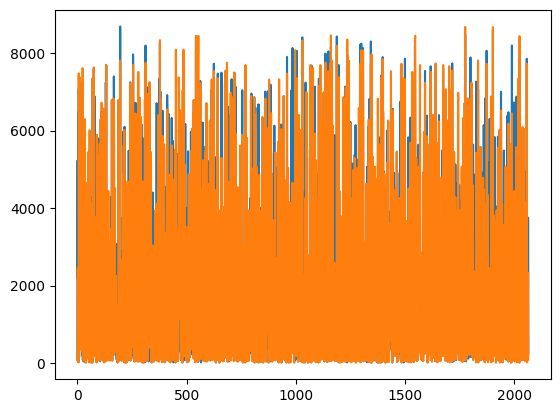

In [33]:
plt.plot(y_test_demand.values.astype(float))
plt.plot(y_pred_demand.astype(float))

In [28]:
len(y_test_demand)*.15

309.9